In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
# %config InlineBackend.figure_format = 'retina'

# Self-Contained Testing Notebook

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import pymaster as nmt

In [3]:
def get_bonus_bins(width=5, top_ell=30, l_min=2):
    """Generate some bins for the low ells"""
    bonus_bin_left, bonus_bin_right = [], []
    counter = 0
    for i in list(range(1,top_ell))[::-1]:
        counter += 1
        if counter % width == 0:
            bonus_bin_left.append(i)
            bonus_bin_right.append(i+width-1)
        elif i == l_min:
            bonus_bin_left.append(i)
            bonus_bin_right.append(width-1)
    return bonus_bin_left[::-1], bonus_bin_right[::-1]

We load in some default bins and beams, and some reference spectra.

In [4]:
lmax = 2508
nside = 2048
f1, f2 = 217, 217
lmax_beam = 3*nside # beam needs to extend to high enough ell for NaMaster

binleft, binright = np.genfromtxt('planck_spectra/binused.dat', 
                                  unpack=True, usecols=(0,1), dtype=((int), (int)))
bonus_left, bonus_right = get_bonus_bins(5, l_min=2)
binleft, binright = np.hstack((bonus_left,binleft)), np.hstack((bonus_right,binright))
ells = np.arange(lmax+1)
bpws = -1+np.zeros_like(ells) #Array of bandpower indices
for i, (bl, br) in enumerate(zip(binleft, binright)):
    bpws[bl:br+1] = i
weights = np.array([l*(l+1) for l in ells])
b = nmt.NmtBin(nside, bpws=bpws, ells=ells, weights=weights, lmax=lmax, is_Dell=False)
db = nmt.NmtBin(nside, bpws=bpws, ells=ells, weights=weights, lmax=lmax, is_Dell=True)

In [5]:
# load in the fiducial beam
beam_filename = f'planck_beam/beam_likelihood_{f1}hm1x{f2}hm2.dat'
beam_ell, beam = np.genfromtxt(beam_filename, unpack=True) # beam file is ell, Bl
default_Bl = np.zeros(lmax_beam)
default_Bl[beam_ell.astype(int)] = beam

In [8]:
lmin_,lmax_,l_ref,cl_ref,error_ref=np.loadtxt('planck_spectra/spectra_' + f'TT_{f1}x{f2}' + '.dat',unpack=True)
ref_fac = l_ref*(l_ref+1)/(2*np.pi)
dl_ref = cl_ref * ref_fac

In [9]:
# pixel_window = hp.sphtfunc.pixwin(nside, pol=False)[:len(Bl)]
pixel_window = np.load('pixwin2048.npy')

In [10]:
def get_binned(rawcl):
    return np.array([ np.sum(
        rawcl[bpws==bi]) / np.sum(bpws==bi) 
                          for bi in range(len(binleft)) ])

# Test 0: Demonstrate the Problem
We compute the 217x217 spectra and demonstrate that something is wrong.

In [11]:
mask = hp.read_map('masks/COM_Mask_Likelihood-temperature-217_2048_R2.00.fits', verbose=False)
map1 = hp.read_map('maps/PR2/frequencyMaps/HFI_SkyMap_217_2048_R2.02_halfmission-1.fits', field=0, verbose=False)
map2 = hp.read_map('maps/PR2/frequencyMaps/HFI_SkyMap_217_2048_R2.02_halfmission-2.fits', field=0, verbose=False)

badpix1 = np.logical_or(map1 < -1e30, map1 > 0.002) 
badpix2 = np.logical_or(map2 < -1e30, map2 > 0.002) 
map1[badpix1] = 0
map2[badpix2] = 0

# NaMaster-CAR only supports niter=0
i0 = nmt.NmtField(mask,[map1], beam=(default_Bl*pixel_window), n_iter=0)
i1 = nmt.NmtField(mask,[map2], beam=(default_Bl*pixel_window), n_iter=0)
cl_nmt_test0 = nmt.compute_full_master(i0,i1,b)[0]
lb = b.get_effective_ells()

/home/zequnl/anaconda3/lib/python3.6/site-packages/healpy/fitsfunc.py:371: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


In [12]:
# must trim low ells off for comparison
lb_nmt_test0 = lb[len(bonus_left):]
dl_nmt_test0 = cl_nmt_test0[len(bonus_left):] * 1e12 * ref_fac

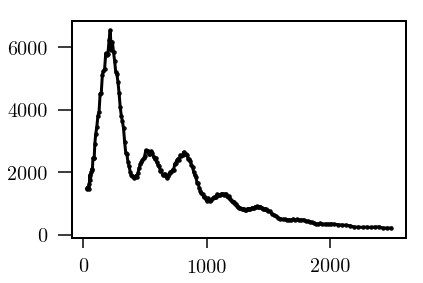

In [13]:
plt.plot(lb_nmt_test0, dl_nmt_test0, 'k.-')

Text(0.5, 1.0, 'houston we have a problem')

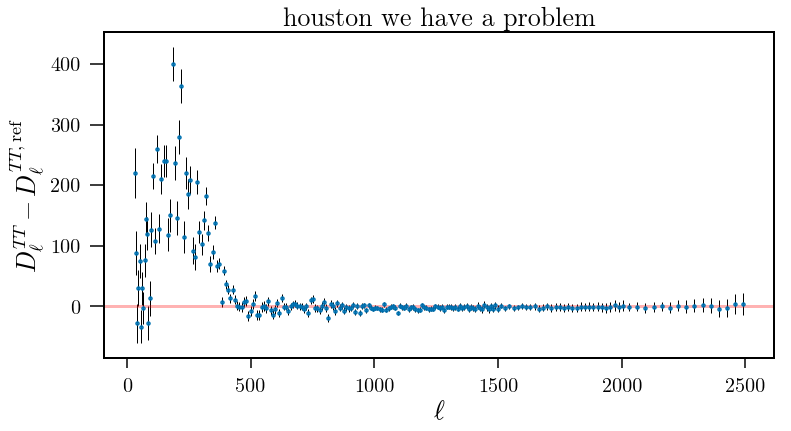

In [14]:
plt.figure(figsize=(12,6))
plt.axhline(0, color='red', alpha=0.3)
plt.errorbar( lb_nmt_test0, dl_nmt_test0 - dl_ref, 
         fmt='.', yerr=error_ref * ref_fac, elinewidth=1, color='#0072B2', ecolor='k')
plt.ylabel(r'$D_{\ell}^{TT} - D_{\ell}^{TT,\mathrm{ref}}$')
plt.xlabel(r'$\ell$')
plt.title('houston we have a problem')

# Test 1: Reference Spectra
It's possible that we messed up reading the reference spectra. We compare it to the Planck CMB bestfit.

In [166]:
! wget https://irsa.ipac.caltech.edu/data/Planck/release_2/ancillary-data/cosmoparams/COM_PowerSpect_CMB-base-plikHM-TT-lowTEB-minimum-theory_R2.02.txt -nc --directory-prefix=testing

--2019-04-08 17:05:26--  https://irsa.ipac.caltech.edu/data/Planck/release_2/ancillary-data/cosmoparams/COM_PowerSpect_CMB-base-plikHM-TT-lowTEB-minimum-theory_R2.02.txt
Resolving irsa.ipac.caltech.edu (irsa.ipac.caltech.edu)... 134.4.54.110
Connecting to irsa.ipac.caltech.edu (irsa.ipac.caltech.edu)|134.4.54.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 205647 (201K) [text/plain]
Saving to: ‘testing/COM_PowerSpect_CMB-base-plikHM-TT-lowTEB-minimum-theory_R2.02.txt.3’

COM_PowerSpect_CMB- 100%[===================>] 200.83K   199KB/s    in 1.0s    

2019-04-08 17:05:28 (199 KB/s) - ‘testing/COM_PowerSpect_CMB-base-plikHM-TT-lowTEB-minimum-theory_R2.02.txt.3’ saved [205647/205647]



In [82]:
bestfit_l, bestfit_tt = np.genfromtxt(
    'testing/COM_PowerSpect_CMB-base-plikHM-TT-lowTEB-minimum-theory_R2.02.txt',
    usecols=(0,1), unpack=True)
bestfit_dl = np.zeros(lmax+1)
bestfit_dl[bestfit_l.astype(int)] = bestfit_tt

(-100, 900)

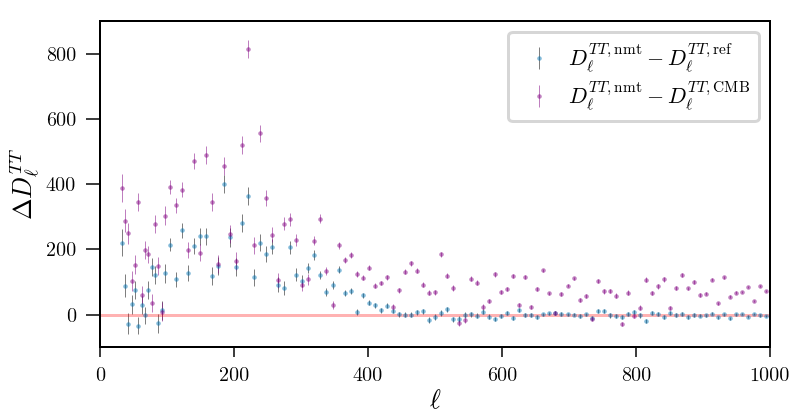

In [84]:
dl_cmb_bestfit = get_binned(bestfit_dl)[len(bonus_left):]

plt.figure(figsize=(12,6))
plt.axhline(0, color='red', alpha=0.3)

plt.errorbar( lb_nmt_test0, dl_nmt_test0 - dl_ref, 
         fmt='.', yerr=error_ref * ref_fac, elinewidth=1, color='#0072B2', ecolor='k', alpha=0.5,
            label=r'$D_{\ell}^{TT,\mathrm{nmt}} - D_{\ell}^{TT,\mathrm{ref}}$')

plt.errorbar( lb_nmt_test0, dl_nmt_test0 - dl_cmb_bestfit, 
         fmt='.', yerr=error_ref * ref_fac, elinewidth=1, color='purple',
            label=r'$D_{\ell}^{TT,\mathrm{nmt}} - D_{\ell}^{TT,\mathrm{CMB}}$', alpha=0.5)

plt.ylabel(r'$\Delta D_{\ell}^{TT}$')
plt.xlabel(r'$\ell$')
plt.legend(frameon=True)
plt.xlim(0,1000)
plt.ylim(-100, 900)

The deviation of our spectrum at low ell also exists in terms of our spectra vs CMB bestfit. Thus, our issue is not with the reference spectra provided by Thibaut.

(-100, 900)

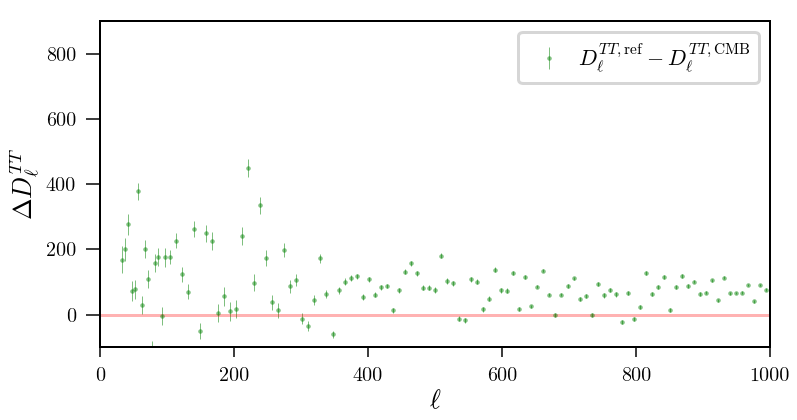

In [190]:
plt.figure(figsize=(12,6))
plt.axhline(0, color='red', alpha=0.3)

plt.errorbar( lb_nmt_test0, dl_ref - dl_cmb_bestfit, 
         fmt='.', yerr=error_ref * ref_fac, elinewidth=1, color='g',
            label=r'$D_{\ell}^{TT,\mathrm{ref}} - D_{\ell}^{TT,\mathrm{CMB}}$', alpha=0.5)

plt.ylabel(r'$\Delta D_{\ell}^{TT}$')
plt.xlabel(r'$\ell$')
plt.legend(frameon=True)
plt.xlim(0,1000)
plt.ylim(-100, 900)

Another way to see this is above, where we subtract Thibaut's reference 217x217 to the CMB bestfit. We see no comparable large scale deviation.

# Test 2: Crosses

We compute the full-mission autospectrum, as well as the even/odd ring cross spectrum.

In [291]:
! wget https://irsa.ipac.caltech.edu/data/Planck/release_2/all-sky-maps/maps/HFI_SkyMap_217_2048_R2.02_full.fits -nc --directory-prefix=testing

--2019-04-08 18:04:32--  https://irsa.ipac.caltech.edu/data/Planck/release_2/all-sky-maps/maps/HFI_SkyMap_217_2048_R2.02_full.fits
Resolving irsa.ipac.caltech.edu (irsa.ipac.caltech.edu)... 134.4.54.110
Connecting to irsa.ipac.caltech.edu (irsa.ipac.caltech.edu)|134.4.54.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2013278400 (1.9G) [image/x-fits]
Saving to: ‘testing/HFI_SkyMap_217_2048_R2.02_full.fits’

HFI_SkyMap_217_2048 100%[===================>]   1.88G  7.91MB/s    in 3m 42s  

2019-04-08 18:08:14 (8.65 MB/s) - ‘testing/HFI_SkyMap_217_2048_R2.02_full.fits’ saved [2013278400/2013278400]



In [292]:
mask = hp.read_map('masks/COM_Mask_Likelihood-temperature-217_2048_R2.00.fits', verbose=False)
map1 = hp.read_map('testing/HFI_SkyMap_217_2048_R2.02_full.fits', field=0, verbose=False)

badpix1 = np.logical_or(map1 < -1e30, map1 > 0.002) 
map1[badpix1] = 0

# NaMaster-CAR only supports niter=0
i0 = nmt.NmtField(mask,[map1], beam=(default_Bl*pixel_window), n_iter=0)
cl_nmt_test2a = nmt.compute_full_master(i0,i0,b)[0]
lb = b.get_effective_ells()

# must trim low ells off for comparison
lb_nmt_test2a = lb[len(bonus_left):]
dl_nmt_test2a = cl_nmt_test2a[len(bonus_left):] * 1e12 * ref_fac

/home/zequnl/anaconda3/lib/python3.6/site-packages/healpy/fitsfunc.py:371: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


Text(0.5, 1.0, 'full mission autos')

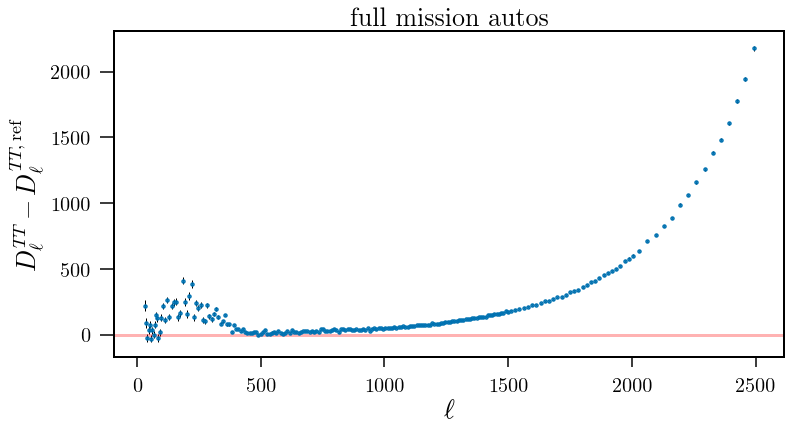

In [294]:
plt.figure(figsize=(12,6))
plt.axhline(0, color='red', alpha=0.3)
plt.errorbar( lb_nmt_test0, dl_nmt_test2a - dl_ref, 
         fmt='.', yerr=error_ref * ref_fac, elinewidth=1, color='#0072B2', ecolor='k')
plt.ylabel(r'$D_{\ell}^{TT} - D_{\ell}^{TT,\mathrm{ref}}$')
plt.xlabel(r'$\ell$')
plt.title('full mission autos')

In [315]:
! wget https://irsa.ipac.caltech.edu/data/Planck/release_2/all-sky-maps/maps/HFI_SkyMap_217_2048_R2.02_full-ringhalf-1.fits -nc --directory-prefix=testing
! wget https://irsa.ipac.caltech.edu/data/Planck/release_2/all-sky-maps/maps/HFI_SkyMap_217_2048_R2.02_full-ringhalf-2.fits -nc --directory-prefix=testing

--2019-04-08 18:18:29--  https://irsa.ipac.caltech.edu/data/Planck/release_2/all-sky-maps/maps/HFI_SkyMap_217_2048_R2.02_full-ringhalf-1.fits
Resolving irsa.ipac.caltech.edu (irsa.ipac.caltech.edu)... 134.4.54.110
Connecting to irsa.ipac.caltech.edu (irsa.ipac.caltech.edu)|134.4.54.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2013278400 (1.9G) [image/x-fits]
Saving to: ‘testing/HFI_SkyMap_217_2048_R2.02_full-ringhalf-1.fits’

HFI_SkyMap_217_2048 100%[===================>]   1.88G  35.4MB/s    in 49s     

2019-04-08 18:19:19 (38.9 MB/s) - ‘testing/HFI_SkyMap_217_2048_R2.02_full-ringhalf-1.fits’ saved [2013278400/2013278400]

--2019-04-08 18:19:20--  https://irsa.ipac.caltech.edu/data/Planck/release_2/all-sky-maps/maps/HFI_SkyMap_217_2048_R2.02_full-ringhalf-2.fits
Resolving irsa.ipac.caltech.edu (irsa.ipac.caltech.edu)... 134.4.54.110
Connecting to irsa.ipac.caltech.edu (irsa.ipac.caltech.edu)|134.4.54.110|:443... connected.
HTTP request sent, awaiting 

In [317]:
mask = hp.read_map('masks/COM_Mask_Likelihood-temperature-217_2048_R2.00.fits', verbose=False)
map1 = hp.read_map('testing/HFI_SkyMap_217_2048_R2.02_full-ringhalf-1.fits', field=0, verbose=False)
map2 = hp.read_map('testing/HFI_SkyMap_217_2048_R2.02_full-ringhalf-2.fits', field=0, verbose=False)

badpix1 = np.logical_or(map1 < -1e30, map1 > 0.002) 
badpix2 = np.logical_or(map2 < -1e30, map2 > 0.002) 
map1[badpix1] = 0
map2[badpix2] = 0

# NaMaster-CAR only supports niter=0
i0 = nmt.NmtField(mask,[map1], beam=(default_Bl*pixel_window), n_iter=0)
i1 = nmt.NmtField(mask,[map2], beam=(default_Bl*pixel_window), n_iter=0)
cl_nmt_test2 = nmt.compute_full_master(i0,i1,b)[0]
lb = b.get_effective_ells()

/home/zequnl/anaconda3/lib/python3.6/site-packages/healpy/fitsfunc.py:371: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


In [318]:
# must trim low ells off for comparison
lb_nmt_test2 = lb[len(bonus_left):]
dl_nmt_test2 = cl_nmt_test2[len(bonus_left):] * 1e12 * ref_fac

Text(0.5, 0, '$\\ell$')

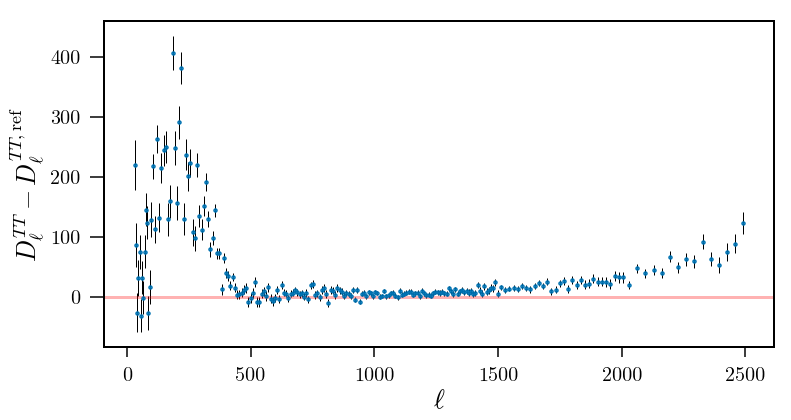

In [320]:
plt.figure(figsize=(12,6))
plt.axhline(0, color='red', alpha=0.3)
plt.errorbar( lb_nmt_test2, dl_nmt_test2 - dl_ref, 
         fmt='.', yerr=error_ref * ref_fac, elinewidth=1, color='#0072B2', ecolor='k')
plt.ylabel(r'$D_{\ell}^{TT} - D_{\ell}^{TT,\mathrm{ref}}$')
plt.xlabel(r'$\ell$')

The signal appears to also be in the even/odd rings! Auto spectrum doesn't really tell us anything.

# Test 3: polspice on 217x217

In [15]:
import ispice

In [16]:
mask = hp.read_map('masks/COM_Mask_Likelihood-temperature-217_2048_R2.00.fits', verbose=False)
map1 = hp.read_map('maps/PR2/frequencyMaps/HFI_SkyMap_217_2048_R2.02_halfmission-1.fits', field=0, verbose=False)
map2 = hp.read_map('maps/PR2/frequencyMaps/HFI_SkyMap_217_2048_R2.02_halfmission-2.fits', field=0, verbose=False)

badpix1 = np.logical_or(map1 < -1e30, map1 > 0.002) 
badpix2 = np.logical_or(map2 < -1e30, map2 > 0.002) 
map1[badpix1] = 0
map2[badpix2] = 0

In [17]:
hp.write_map('window.fits', mask, overwrite=True)
hp.write_map('split1.fits', map1, overwrite=True)
hp.write_map('split2.fits', map2, overwrite=True)

In [173]:
ispice.ispice(mapin1='split1.fits', weightfile1='window.fits',
              mapfile2='split2.fits', weightfile2='window.fits',
              nlmax=3100, 
#               apodizesigma=180, thetamax=180, 
#               subav='YES',
              clout='cl.fits')

Submitting job 0
/home/zequnl/Installs/PolSpice_v03-05-01/bin/./spice -apodizesigma NO -apodizetype 0 -beam NO -beam2 NO -clfile cl.fits -decouple NO -mapfile split1.fits -mapfile2 split2.fits -fits_out YES -weightfile window.fits -weightfile2 window.fits -nlmax 3100 -normfac 1.00000 -npairsthreshold 0.00000 -overwrite YES -polarization NO -pixelfile YES -pixelfile2 YES -subav NO -subdipole NO -symmetric_cl NO -thetamax NO -tolerance NO -verbosity 2 -weightpower 1.0 -weightpower2 1.0 -weightpowerp 1.0 -weightpowerp2 1.0 


0

In [174]:
from astropy.io import fits
pixwin = hp.sphtfunc.pixwin(nside)
rawcl = fits.open('cl.fits')[1].data['TT'] / default_Bl[:3101]**2 #/ pixel_window**2

In [175]:
dl_polspice = get_binned(
    rawcl[:2509] * np.arange(2509)**2 * 1e12 / 2 / np.pi
)[len(bonus_left):]

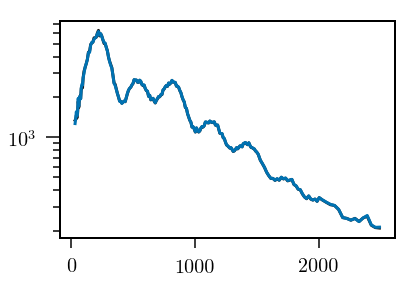

In [176]:
plt.plot(l_ref, dl_polspice)
plt.plot(l_ref, dl_ref)
plt.yscale('log')

In [177]:
# plt.plot( l_ref, (dl_polspice - dl_ref) / (error_ref * ref_fac) )

Text(0.5, 0, '$\\ell$')

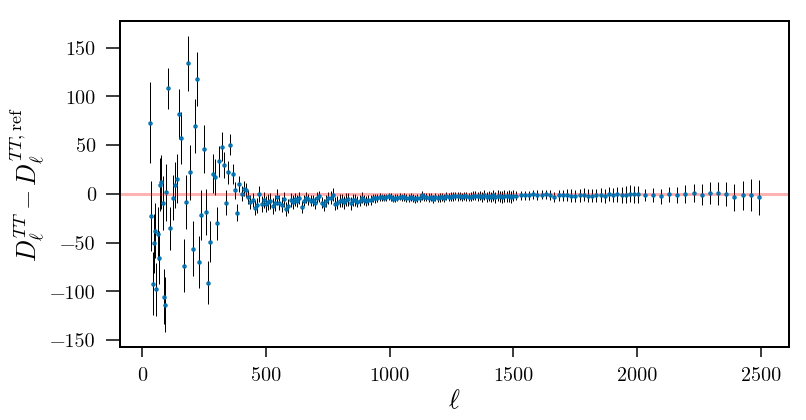

In [178]:
plt.figure(figsize=(12,6))
plt.axhline(0, color='red', alpha=0.3)
plt.errorbar( l_ref, dl_polspice - dl_ref, 
         fmt='.', yerr=error_ref * ref_fac, elinewidth=1, color='#0072B2', ecolor='k')

plt.ylabel(r'$D_{\ell}^{TT} - D_{\ell}^{TT,\mathrm{ref}}$')
plt.xlabel(r'$\ell$')

I couldn't get the small scales to actually agree with polspice, but the feature is certainly still in this spectrum!

# Test 4 : monopole and dipole

In [60]:
# load in the fiducial beam
beam_filename = f'planck_beam/beam_likelihood_217hm1x217hm2.dat'
beam_ell, beam = np.genfromtxt(beam_filename, unpack=True) # beam file is ell, Bl
default_Bl = np.zeros(lmax_beam)
default_Bl[beam_ell.astype(int)] = beam

In [61]:
mask = hp.read_map('masks/COM_Mask_Likelihood-temperature-217_2048_R2.00.fits', verbose=False)
map1 = hp.read_map('maps/PR2/frequencyMaps/HFI_SkyMap_217_2048_R2.02_halfmission-1.fits', field=0, verbose=False)
map2 = hp.read_map('maps/PR2/frequencyMaps/HFI_SkyMap_217_2048_R2.02_halfmission-2.fits', field=0, verbose=False)

badpix1 = (map1 < -1e30) 
badpix2 = (map2 < -1e30) 
map1[badpix1] = 0
map2[badpix2] = 0

/home/zequnl/anaconda3/lib/python3.6/site-packages/healpy/fitsfunc.py:371: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


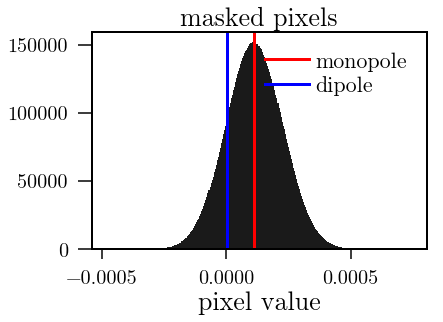

In [62]:
map_masked = hp.ma(map1.copy())
map_masked.mask = (mask<1)
mono, dipole = hp.pixelfunc.fit_dipole(map_masked)
    
plt.hist(map1[~(mask<1) ], bins=300);
plt.axvline(mono, color='r', label='monopole')
plt.axvline( np.sqrt( np.sum(dipole**2) ), color='b', label='dipole')
plt.title('masked pixels')
plt.xlabel('pixel value')
plt.legend()

In [179]:
def subtract_mono_di(map_in, mask_in):
    map_masked = hp.ma(map_in)
    map_masked.mask = (mask_in<1)
    mono, dipole = hp.pixelfunc.fit_dipole(map_masked)
    
    m = map_in.copy()
    npix = hp.nside2npix(nside)
    bunchsize = npix // 24
    bad = hp.UNSEEN
    for ibunch in range(npix // bunchsize):
        ipix = np.arange(ibunch * bunchsize, (ibunch + 1) * bunchsize)
        ipix = ipix[(np.isfinite(m.flat[ipix]))]
        x, y, z = hp.pix2vec(nside, ipix, False)
#         m.flat[ipix] -= dipole[0] * x
#         m.flat[ipix] -= dipole[1] * y
#         m.flat[ipix] -= dipole[2] * z
        m.flat[ipix] -= mono
        
    return m

In [180]:
map1_subtracted = subtract_mono_di(map1, mask)
map2_subtracted = subtract_mono_di(map2, mask)

In [65]:
hp.write_map('window.fits', mask, overwrite=True)
hp.write_map('split1_sub.fits', map1_subtracted, overwrite=True)
hp.write_map('split2_sub.fits', map2_subtracted, overwrite=True)

In [181]:
i0 = nmt.NmtField(mask,[map1_subtracted], beam=(default_Bl*pixel_window), n_iter=0)
i1 = nmt.NmtField(mask,[map2_subtracted], beam=(default_Bl*pixel_window), n_iter=0)
cl_nmt_test4 = nmt.compute_full_master(i0,i1,b)[0]
lb = b.get_effective_ells()

In [182]:
# must trim low ells off for comparison
lb_nmt_test0 = lb[len(bonus_left):]
dl_nmt_test0 = cl_nmt_test0[len(bonus_left):] * 1e12 * ref_fac

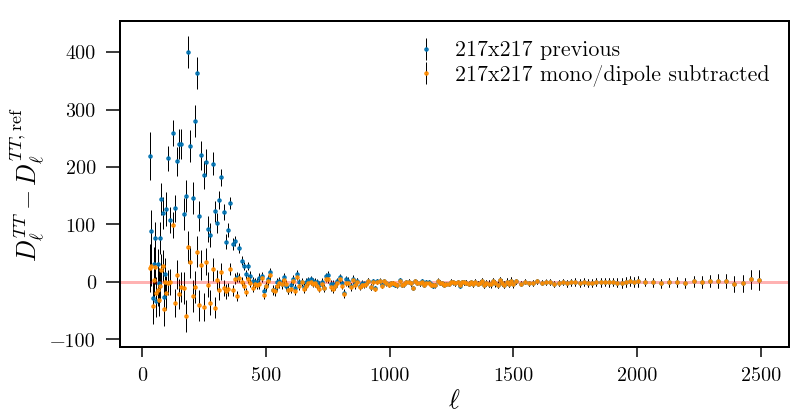

In [183]:
# must trim low ells off for comparison
lb_nmt_test4 = lb[len(bonus_left):]
dl_nmt_test4 = cl_nmt_test4[len(bonus_left):] * 1e12 * ref_fac

plt.figure(figsize=(12,6))
plt.axhline(0, color='red', alpha=0.3)
plt.errorbar( lb_nmt_test0, dl_nmt_test0 - dl_ref, 
         fmt='.', yerr=error_ref * ref_fac, elinewidth=1, color='#0072B2', ecolor='k',
            label='217x217 previous')
plt.errorbar( lb_nmt_test4, dl_nmt_test4 - dl_ref, 
         fmt='.', yerr=error_ref * ref_fac, elinewidth=1, color='darkorange', ecolor='k',
            label='217x217 mono/dipole subtracted')


plt.ylabel(r'$D_{\ell}^{TT} - D_{\ell}^{TT,\mathrm{ref}}$')
plt.xlabel(r'$\ell$')
plt.legend()

In [184]:

# plt.figure(figsize=(12,6))
# plt.axhline(0, color='red', alpha=0.3)

# plt.errorbar( lb_nmt_test4, dl_nmt_test4 - dl_ref, 
#          fmt='.', yerr=error_ref * ref_fac, elinewidth=1, color='darkorange', ecolor='k',
#             label='217x217 mono/dipole subtracted')


# plt.ylabel(r'$D_{\ell}^{TT} - D_{\ell}^{TT,\mathrm{ref}}$')
# plt.xlabel(r'$\ell$')
# plt.legend()

Text(0, 0.5, '$\\Delta C_{\\ell} / \\sigma$')

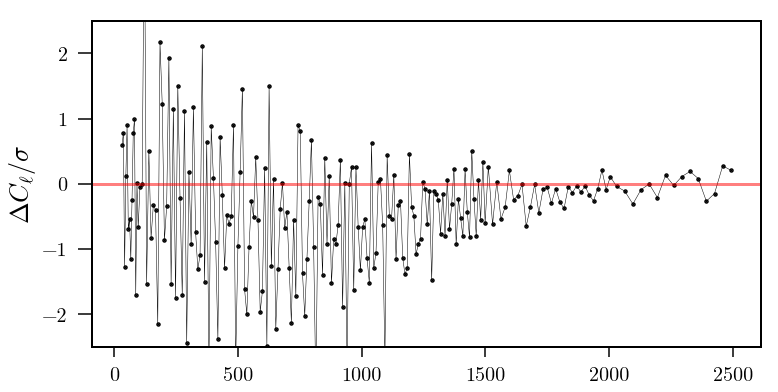

In [185]:
plt.figure(figsize=(12,6))
plt.plot( lb_nmt_test4, (dl_nmt_test4 - dl_ref) / (error_ref*ref_fac), 'k.-', lw=0.5 )
plt.axhline(0.0, color='r', alpha=0.5)
plt.ylim(-2.5,2.5)
plt.ylabel(r'$\Delta C_{\ell} / \sigma$')

In [85]:

weeighted_lb_nmt_test4 = weighted_lb[len(bonus_left):]
weighted_dl_nmt_test4 = weighted_cl_nmt_test4[len(bonus_left):] * 1e12